# Pixel Generation using RNNs
Here the goal is to generate images based on the fact that some part is given(like the input is the top half and the job of the model isto predict the bottom half). So that the resulting image is a complete image

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Loading Data
The following block of code loads MNIST data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [2]:
# df_train, df_test = tf.keras.datasets.mnist.load_data()

(df_train, df_test), df_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files = False,
    with_info = True,
    as_supervised = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
df_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## Labels for the data & Look at the data

In [4]:
{df_info.features['label'].str2int(x):x for x in df_info.features['label'].names}

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

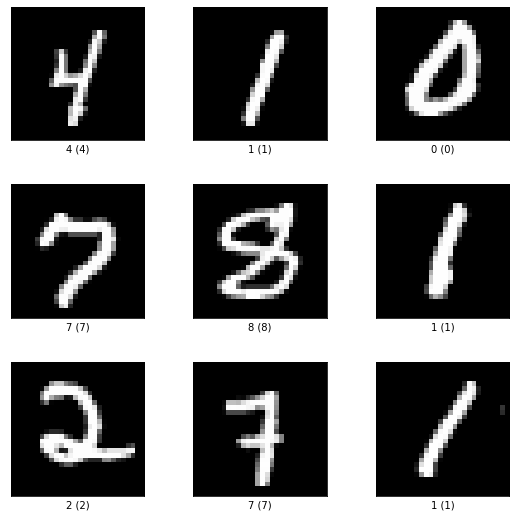

In [5]:
fig = tfds.show_examples(df_train, df_info)

Processing the dataset and turning each set into a trainable and testable sets.

In [ ]:
# (df_train, df_test), df_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files = False,
#     with_info = True,
#     as_supervised = True
# )

# def normalize(image, label):
#     return tf.cast(image, tf.float32) / 255., tf.one_hot(label, depth=10)

# def convert_image_into_sequences(image, label):
#     image = tf.constant(image).numpy()
#     # image_flat = tf.Variable(np.zeros((16, 49)), dtype=np.float32)
#     image_flat = np.zeros((16, 49))
#     i = 0
#     for x in range(0,21, 7):
#         for y in range(0, 21, 7):
#             # image_flat[i,:] = tf.reshape(image[x:x+7, y:y+7], [-1])
#             image_flat[i,:] = image[x:x+7, y:y+7].flatten()
#             i += 1
#     return image_flat[:15], image_flat[1:]

# df_train = df_train.map(normalize, 
#                         num_parallel_calls = tf.data.experimental.AUTOTUNE)
# df_train = df_train.map(convert_image_into_sequences, 
#                         num_parallel_calls = tf.data.experimental.AUTOTUNE)
# df_train = df_train.cache()
# df_train = df_train.shuffle(df_info.splits['train'].num_examples)
# df_train = df_train.batch(BATCH_SIZE)
# df_train = df_train.prefetch(tf.data.experimental.AUTOTUNE)

# df_test = df_test.map(normalize, 
#                       num_parallel_calls = tf.data.experimental.AUTOTUNE)
# df_test = df_test.map(convert_image_into_sequences, 
#                       num_parallel_calls = tf.data.experimental.AUTOTUNE)
# df_test = df_test.cache()
# df_test = df_test.batch(BATCH_SIZE)
# df_test = df_test.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# checkpoint = keras.callbacks.ModelCheckpoint('', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

## Preprocessing the images and labels
Converting the input and generating the output in the format of :
- Divide the image into 2 parts - Top and bottom
- Where the top part will be used to predict the bottom half
- So, the bottom half is the target 

In [8]:
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()
train_imgs = 2*((train_imgs/255.)-0.5)
test_imgs = 2*((test_imgs/255.)-0.5)

def convert_image_into_sequences(image):
    image_flat = np.zeros((16, 49))
    i = 0
    for x in range(0,22, 7):
        for y in range(0, 22, 7):
            image_flat[i,:] = image[x:x+7, y:y+7].flatten()
            i += 1
    return image_flat, image_flat[:15], image_flat[1:]

df_train = []
train_target = []

df_test = []
train_test = []

for image in train_imgs:
    _, x, y = convert_image_into_sequences(image)
    df_train.append(x)
    train_target.append(y)

for image in test_imgs:
    _, x, y = convert_image_into_sequences(image)
    df_test.append(x)
    train_test.append(y)

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
df_train = np.stack(df_train)
train_target = np.stack(train_target)

df_test = np.stack(df_test)
train_test = np.stack(train_test)


## Custom Loss function

In [ ]:
def my_loss_fn(y_true, y_pred):
    # Euclidean Distance between vectors
    summ = tf.reduce_mean((y_true - y_pred)**2, 1)
    return tf.reduce_mean(summ)

## Model architecture

In [49]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(None, 49)),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(128, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(49, activation = 'tanh')
])
model.compile(loss = my_loss_fn,
              optimizer = 'adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, None, 64)          29184     
                                                                 
 batch_normalization_24 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_25 (LSTM)              (None, None, 128)         98816     
                                                                 
 batch_normalization_25 (Bat  (None, None, 128)        512       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, None, 128)        

In [50]:
df_test.shape, df_train.shape

((10000, 15, 49), (60000, 15, 49))

## Training
With early stopping over validation data and taking the minimum of the last 10 epochs

In [51]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(df_train, train_target, validation_data = (df_test, train_test), epochs=200, batch_size=100, callbacks = [es])

Epoch 1/200
600/600 [==============================] - 14s 14ms/step - loss: 0.3641 - val_loss: 0.2263
Epoch 2/200
600/600 [==============================] - 7s 11ms/step - loss: 0.1947 - val_loss: 0.1596
Epoch 3/200
600/600 [==============================] - 7s 12ms/step - loss: 0.1712 - val_loss: 0.1443
Epoch 4/200
600/600 [==============================] - 7s 12ms/step - loss: 0.1592 - val_loss: 0.1366
Epoch 5/200
600/600 [==============================] - 7s 12ms/step - loss: 0.1515 - val_loss: 0.1328
Epoch 6/200
600/600 [==============================] - 6s 11ms/step - loss: 0.1463 - val_loss: 0.1283
Epoch 7/200
600/600 [==============================] - 7s 11ms/step - loss: 0.1425 - val_loss: 0.1285
Epoch 8/200
600/600 [==============================] - 6s 11ms/step - loss: 0.1396 - val_loss: 0.1258
Epoch 9/200
600/600 [==============================] - 7s 12ms/step - loss: 0.1374 - val_loss: 0.1226
Epoch 10/200
600/600 [==============================] - 7s 11ms/step - loss: 0.13

## Plot of the Loss

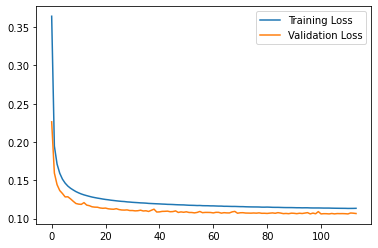

In [52]:
plt.plot(model.history.history['loss'], label = 'Training Loss')
plt.plot(model.history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc='upper right')

## Plotting of the output

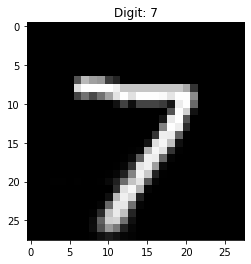

In [54]:
def convert_sequences_into_image(seqs):
    image = np.zeros((28, 28))
    i = 0
    for x in range(0,22, 7):
        for y in range(0, 22, 7):
            image[x:x+7, y:y+7] = seqs[i,:].reshape((7, 7))
            # print(x:x+7, y:y+7)
            i += 1
            # print(i)
    return image

test_img = df_test[0][:8]

temp_img = test_img.copy()
for _ in range(8):
    pred = model.predict(tf.expand_dims(temp_img, 0))
    temp_img = np.concatenate((temp_img, pred[:,-1,:])) 
plt.imshow(convert_sequences_into_image(temp_img), cmap='gray')
plt.title("Digit: %d" % (test_labels[0]))
plt.show()


Printing the Real digits


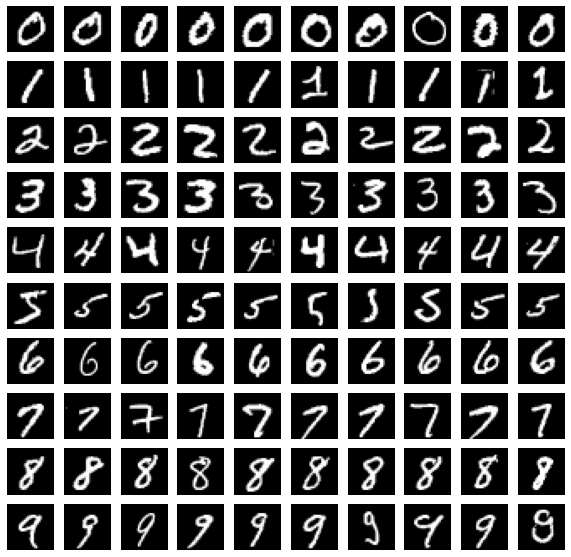




Printing the predicted digits


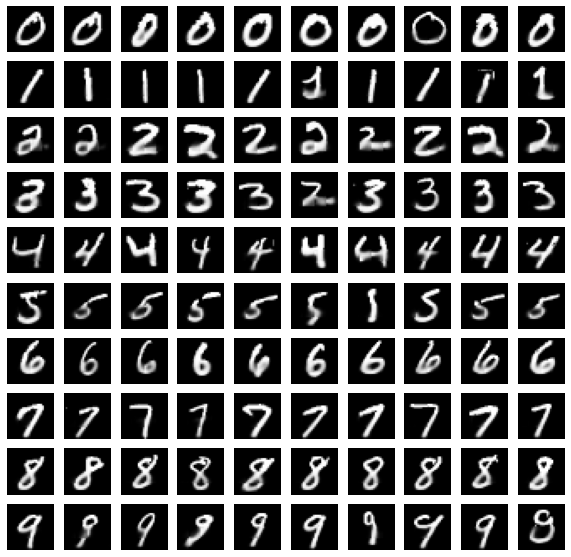

In [55]:
def plot_images(mod, data, labels):
    indexes = np.zeros((10,10))
    for i in range(10):
        indexes[i, :] = np.where(labels == i)[0][:10]
    
    print("\nPrinting the Real digits")
    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            ax.imshow(data[int(indexes[i][j])], cmap='gray')
            plt.axis('off')
    plt.show()
    print("\n\n\nPrinting the predicted digits")

    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))

            x,_,_ = convert_image_into_sequences(data[int(indexes[i][j])])
            temp_img = x[:8].copy()
            for _ in range(8):
                pred = model.predict(tf.expand_dims(temp_img, 0))
                temp_img = np.concatenate((temp_img, pred[:,-1,:])) 
            # try:
            ax.imshow(convert_sequences_into_image(temp_img), cmap='gray')#.reshape((28,28)))
            # except:
            #     pass
            plt.axis('off')
    plt.show()

plot_images(model, train_imgs, train_labels)